In [1]:
import scipy
import numpy
import pandas
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine

%matplotlib inline
import cPickle as pickle
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
class Model():
    def load_histo(self):
        print 'Loading histogram'
        histo = numpy.empty((self.vocabs_count, self.senses_count, 10), dtype=int)
        with open('./data/community_histo') as histo_file:
            for vocab_i in range(0, self.vocabs_count):
                line = next(histo_file).strip().split(' ')
                vocab = line[0]
                sense_count = int(line[1])
            
                for sense_i in range(0, sense_count):
                    line = next(histo_file).strip().split(' ')
                    line_histo = [int(count) for count in line]
                    histo[vocab_i][sense_i] = line_histo
        self.histo = histo
    
    def load_vectors(self):
        print 'Loading vectors'
        with open('./data/vectors-mssg') as vectors_file:
            details = next(vectors_file).strip().split(' ')

            vocabs_count = int(details[0])
            dim = int(details[1])
            senses_count = int(details[2])

            vocabs = []
            sense_weights = numpy.empty((vocabs_count, senses_count, dim), dtype=float)
            global_weights = numpy.empty((vocabs_count, dim), dtype=float)
            nclusters = numpy.empty(vocabs_count, dtype=int)

            for vocab_i in range(0, vocabs_count):
                line = next(vectors_file).strip().split(' ')
                vocabs.append(line[0].lower())
                nclusters[vocab_i] = int(line[1])

                # global weights
                line = next(vectors_file).strip().split(' ')
                line_weights = [float(weight) for weight in line]
                global_weights[vocab_i] = line_weights
                global_weights[vocab_i] /= norm(global_weights[vocab_i], 2)

                for sense_i in range(0, nclusters[vocab_i]):
                    line = next(vectors_file).strip().split(' ')
                    line_weights = [float(weight) for weight in line]
                    sense_weights[vocab_i][sense_i] = line_weights
                    sense_weights[vocab_i][sense_i] /= norm(sense_weights[vocab_i][sense_i], 2)
        
        self.vocabs_count = vocabs_count
        self.dim = dim
        self.senses_count = senses_count
        self.vocabs = vocabs
        self.sense_weights = sense_weights
        self.global_weights = global_weights
        self.nclusters = nclusters
    
    def load(self):
        self.load_vectors()
        self.load_histo()
    
    def similars(self, word, n=10):
        word_index = [ind for ind, vocab in enumerate(self.vocabs) if vocab == word]
        if len(word_index) == 0:
            print 'No such word'
            return

        word_index = word_index[0]

        # closest global
        global_weight = self.global_weights[word_index]
        global_distances = numpy.array([cosine(global_weight, self.global_weights[i]) for i in range(0, self.vocabs_count)])
        global_topn = numpy.argsort(global_distances)[:n]
        global_words = [(self.vocabs[i], global_distances[i]) for i in global_topn]

        # closest senses
        senses_words = []
        n_senses = self.nclusters[word_index]
        for i_sense in range(0, n_senses):
            sense_weight = self.sense_weights[word_index][i_sense]
            sense_distances = []
            for i in range(0, self.vocabs_count):
                for j in range(0, self.nclusters[i]):
                    sense_distances.append((self.vocabs[i], cosine(sense_weight, self.sense_weights[i][j])))
            sense_words = sorted(sense_distances, key=lambda t: t[1])[:10]
            senses_words.append((sense_words, self.histo[word_index][i_sense]))

        return global_words, senses_words

In [3]:
model = Model()
model.load()

Loading vectors
Loading histogram


In [4]:
COMMUNITIES = ['entertainment', 'gaming', 'humor', 'learning', 'lifestyle', 'news', 'television']

In [5]:
global_words, senses_words = model.similars('dark')

In [6]:
global_words

[('dark', 0.0),
 ('begone', 0.50850239801291242),
 ('sickle', 0.51893868288635758),
 ('souls', 0.56108860599068433),
 ('sif', 0.56330434465501389),
 ('smough', 0.58085686435392381),
 ('varus', 0.58094605814432709),
 ('ornstein', 0.58560909989041365),
 ('uhh', 0.590441406567353),
 ('caribbean', 0.59101684702634416)]

In [7]:
def draw(senses, i):
    fig = plt.figure()
    s = senses[i]
    words = [t[0] for t in s[0]]
#     print words
    fig.suptitle(words, fontsize='10')
    plt.bar(range(0, len(COMMUNITIES)), s[1][:len(COMMUNITIES)], align='center')
    plt.xticks(range(0, len(COMMUNITIES)), COMMUNITIES, rotation='vertical')

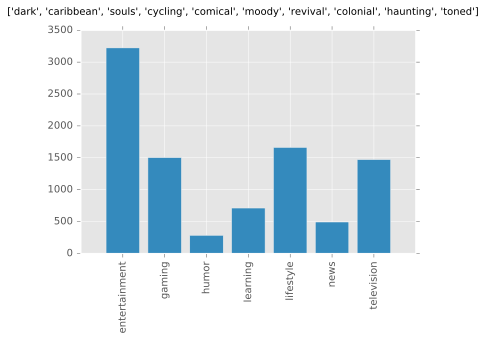

In [8]:
draw(senses_words, 0)

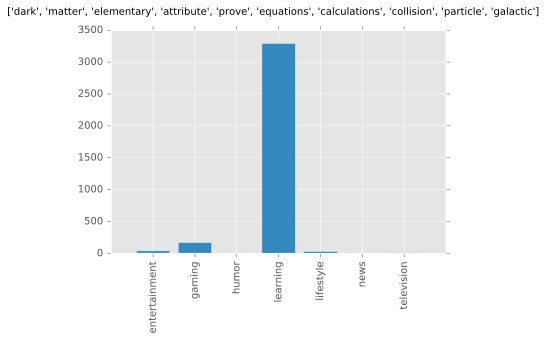

In [9]:
draw(senses_words, 1)

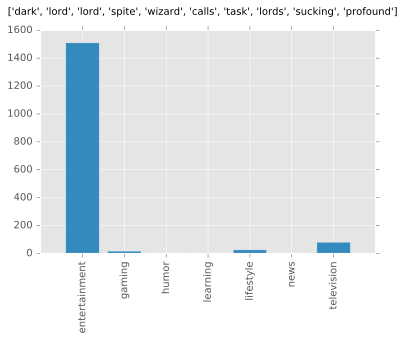

In [10]:
draw(senses_words, 2)

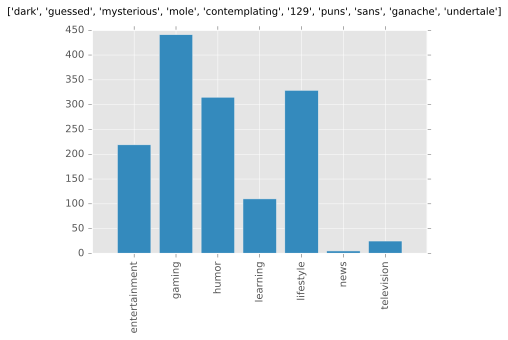

In [11]:
draw(senses_words, 3)

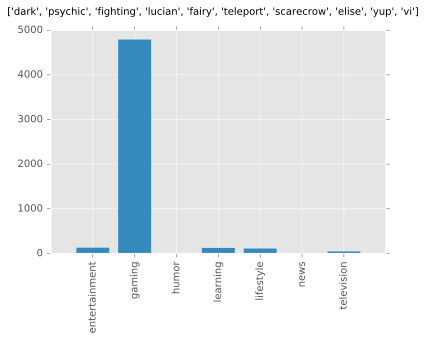

In [12]:
draw(senses_words, 4)

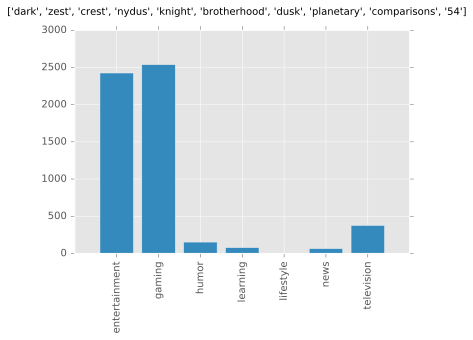

In [13]:
draw(senses_words, 5)

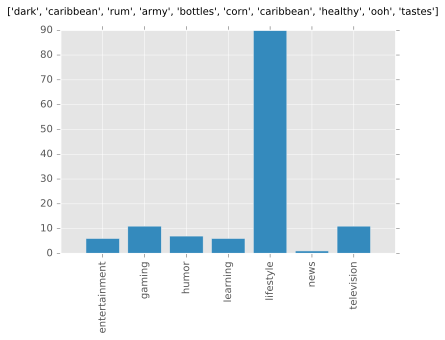

In [14]:
draw(senses_words, 6)

In [51]:
global_words, senses_words = model.similars('league')

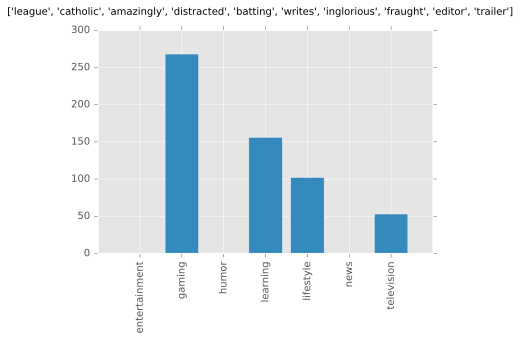

In [52]:
draw(senses_words, 0)

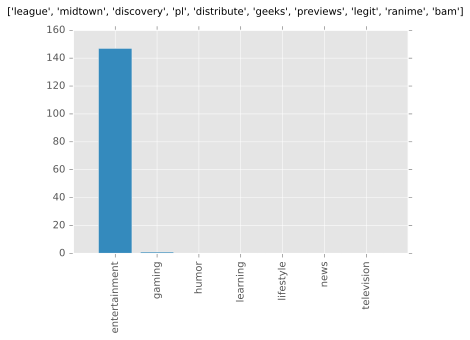

In [53]:
draw(senses_words, 1)

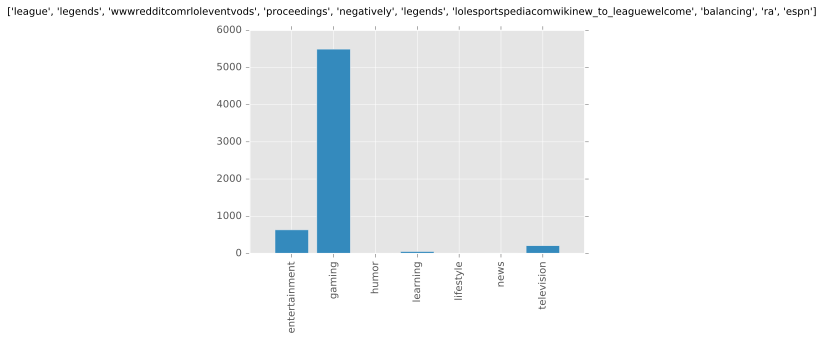

In [54]:
draw(senses_words, 2)

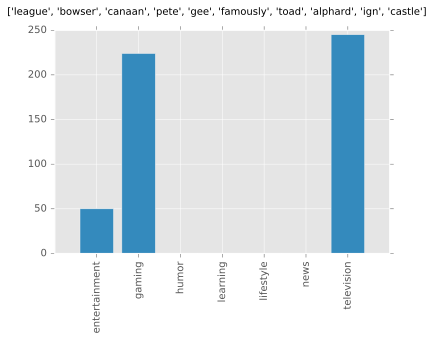

In [19]:
draw(senses_words, 3)

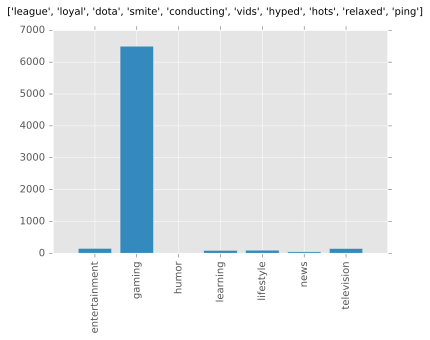

In [20]:
draw(senses_words, 4)

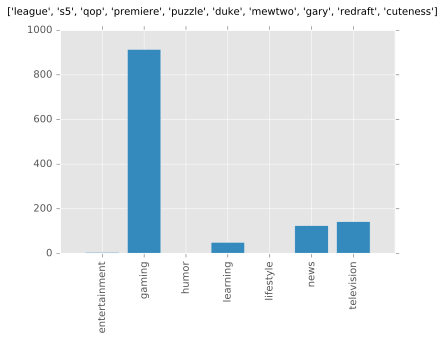

In [21]:
draw(senses_words, 5)

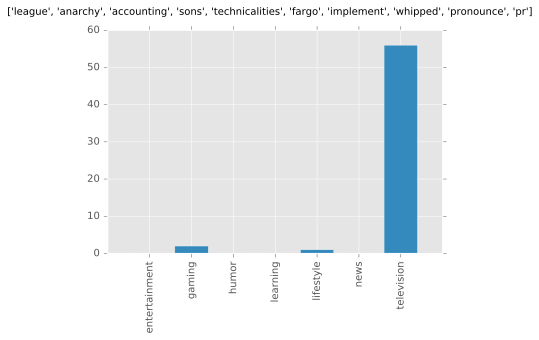

In [22]:
draw(senses_words, 6)

In [23]:
global_words, senses_words = model.similars('wand')

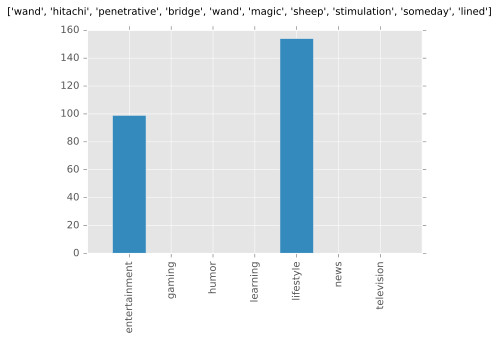

In [28]:
draw(senses_words, 1)

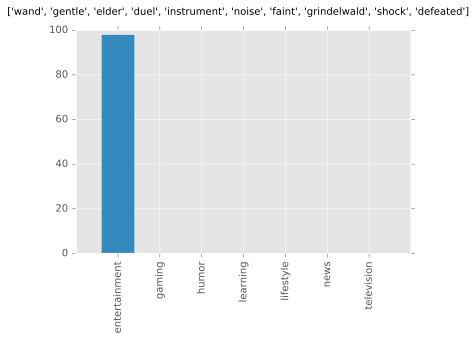

In [33]:
draw(senses_words, 4)

In [34]:
from scipy.stats import entropy

# truncate to 7

histo = numpy.empty((model.vocabs_count, model.senses_count, 7), dtype=float)

for vocab_i in range(0, model.vocabs_count):
    sense_count = model.nclusters[vocab_i]
    for sense_i in range(0, sense_count):
        histo[vocab_i][sense_i] = model.histo[vocab_i][sense_i][:7] / float(numpy.sum(model.histo[vocab_i][sense_i][:7]))

In [35]:
histo

array([[[  7.64484720e-02,   6.42694174e-02,   1.71406536e-01, ...,
           4.56859154e-01,   6.93788361e-02,   7.89228446e-02],
        [  5.79535805e-02,   6.09255590e-01,   6.46759128e-02, ...,
           9.81106708e-02,   5.28233796e-02,   4.16430795e-02],
        [  2.75142441e-01,   2.04617729e-01,   1.04346098e-01, ...,
           6.86034186e-02,   9.70584338e-02,   1.39492514e-01],
        ..., 
        [  1.76591443e-01,   1.19814767e-01,   5.57331072e-02, ...,
           8.58335507e-02,   1.10259588e-01,   1.87059744e-01],
        [  5.08042088e-02,   4.71343789e-02,   1.29476189e-01, ...,
           5.27251355e-02,   5.15783136e-01,   4.41239714e-02],
        [  3.14511746e-01,   4.78591702e-02,   3.44525636e-02, ...,
           3.82571411e-02,   3.52980252e-02,   4.97524005e-01]],

       [[  0.00000000e+00,   0.00000000e+00,   5.81806283e-01, ...,
           6.54450262e-04,   2.99083770e-01,   0.00000000e+00],
        [  9.89853997e-04,   5.93912398e-03,   1.04677060e-0

In [36]:
uniform = numpy.array([1,1,1,1,1,1,1], dtype=float) / 7
uniform

array([ 0.14285714,  0.14285714,  0.14285714,  0.14285714,  0.14285714,
        0.14285714,  0.14285714])

In [37]:
divergence = numpy.empty((model.vocabs_count, model.senses_count, 1), dtype=float)

for vocab_i in range(0, model.vocabs_count):
    sense_count = model.nclusters[vocab_i]
    for sense_i in range(0, sense_count):
        divergence[vocab_i][sense_i] = entropy(histo[vocab_i][sense_i], uniform)

In [55]:
print divergence[model.vocabs.index('good')]

[[ 0.14463918]
 [ 0.52091641]
 [ 0.06240066]
 [ 0.53456988]
 [ 0.07151459]
 [ 0.44972733]
 [ 0.54374559]]


In [56]:
print divergence[model.vocabs.index('money')]

[[ 0.00648365]
 [ 0.43071434]
 [ 0.44830668]
 [ 0.24518687]
 [ 0.14681329]
 [ 0.31814621]
 [ 0.74424692]]


In [65]:
print divergence[model.vocabs.index('people')]

[[ 0.16257816]
 [ 0.14932918]
 [ 0.20445455]
 [ 0.09279462]
 [ 0.05849862]
 [ 0.7711894 ]
 [ 0.1302974 ]]


In [66]:
print divergence[model.vocabs.index('dark')]

[[ 0.22922427]
 [ 1.62014716]
 [ 1.59789641]
 [ 0.34249047]
 [ 1.54230648]
 [ 0.83141833]
 [ 0.79688892]]


In [67]:
print divergence[model.vocabs.index('league')]

[[ 0.71126526]
 [ 1.90541132]
 [ 1.42980752]
 [ 1.00348243]
 [ 1.54250742]
 [ 1.09152749]
 [ 1.71254201]]


In [68]:
print divergence[model.vocabs.index('energy')]

[[ 1.25390694]
 [ 1.78911173]
 [ 0.9713144 ]
 [ 0.35988065]
 [ 0.66377291]
 [ 1.46802072]
 [ 1.70487414]]


In [209]:
global_words_energy, senses_words_energy = model.similars('energy')

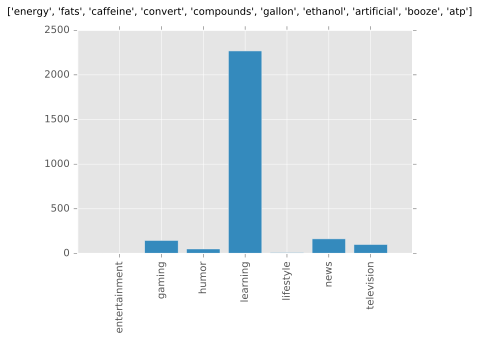

In [210]:
draw(senses_words_energy, 0)

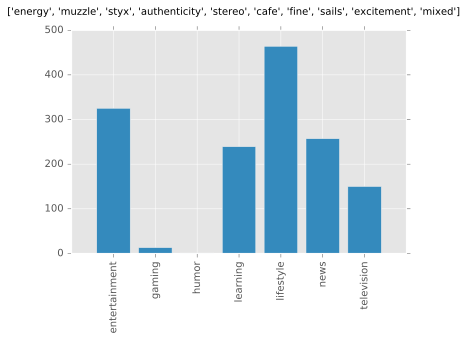

In [211]:
draw(senses_words_energy, 3)

In [44]:
divergence_all = []
for vocab_i in range(0, model.vocabs_count):
    sense_count = model.nclusters[vocab_i]
    for sense_i in range(0, sense_count):
        divergence_all.append(float(divergence[vocab_i][sense_i]))

divergence_all = numpy.array(divergence_all, dtype=float)

In [45]:
divergence_all = numpy.nan_to_num(divergence_all)

In [48]:
divergence_all = divergence_all[divergence_all < 1.94]

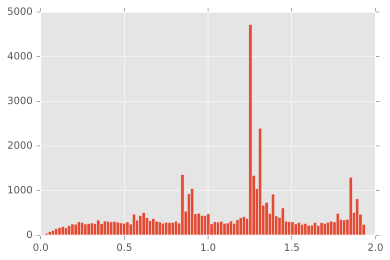

In [49]:
plt.hist(divergence_all, bins=100)
plt.show()

In [198]:
numpy.max(divergence_all)

0.039755402515463723

In [184]:
entropy(numpy.array([1,1,1,1,1,1,1]), numpy.array([999,1,1,1,1,1,1]))

3.9801534173452113